In [1]:
import numpy as np
from sklearn.neighbors import BallTree
# from sklearn.metrics.pairwise import haversine_distances # no need!
import astropy.cosmology as ac
from typing import Any 

import time, sys
DEBUG = 1

In [2]:
def get_neighbour_indices(z: float, cat: Any, cm: ac.Cosmology, center_point: Any, b: float = 10.) -> Any:

    # Checks:
    # NOTE: for compatibility with sklearn's `query_radius` function, which accepts 
    # multiple center points, argument `center_point` must be a 2d array, allowing 
    # multiple queries.
    assert isinstance(z, (int, float)), 'redshift must be a number'
    assert z + 1. > 0., 'redshift must be greater than -1' 
    assert np.ndim( cat ) == 2, 'catalog must be a 2D array'
    assert np.size( cat, 1 ) == 2, 'catalog must have exactly 2 freatures'
    assert isinstance( cm, ac.Cosmology ), '`cm` must be a astropy `Cosmology` object' 
    assert np.ndim( center_point ) == 2, '`center_point` must be a 2D array'
    assert np.size( center_point, 1 ) == 2, '`center_point` must have exactly 2 freatures'

    # calculate the value of the comoving distance corresponding to `z` in Mpc
    # astropy returns value as `Quantity` object and extract the value from it!
    x = cm.comoving_distance( z ).value

    # compute the angular distance in radian, corresponding to `x` radius
    theta = b / x

    # build the ball tree using the given angular coordinates. the first feature 
    # should be the `dec` and the other is `ra`, both in radians
    # 
    # NOTE: using the conversion ra == tongitude and dec == latitude
    if DEBUG:
        __t0 = time.time()
    bt = BallTree( cat, leaf_size = 10, metric = 'haversine' )
    if DEBUG:
        print(f"Time to create tree for {np.size(cat, 0):,} objects: {time.time() - __t0:.3g} sec")
        print(f"Size of the ball-tree object: {sys.getsizeof(bt):,} bytes")

    # search for nearest neighbors in `theta` distance from the center point
    if DEBUG:
        __t0 = time.time()
    nnids, dist = bt.query_radius( center_point, theta, return_distance = True )
    print(f"Time to searching tree for {np.size(center_point, 0)} objects: {time.time() - __t0:.3g} sec")

    return nnids, dist



In [3]:
def haversine_distance(x, y):

    return 2. * np.arcsin( 
            np.sqrt( 
                np.sin(0.5*(x[0] - y[0]))**2 + np.cos(x[0]) * np.cos(y[0]) * np.sin(0.5*(x[1] - y[1]))**2 
                ) 
            )


In [7]:
# using a redshift closer to 0 to get a large angle
z = 0.005

# using 1000 random points on the sphere as galaxies
cat = np.random.uniform( [-np.pi/2., 0.], [np.pi/2., 2*np.pi], size = [100_000, 2] ) 

# using a flat lcdm model cosmology
cm  = ac.FlatLambdaCDM(H0 = 70.0, Om0 = 0.3, Tcmb0 = 2.725, Ob0 = 0.05)

# find the neighbours around random point
p = np.array([[0.01, 0.01]]) #np.random.uniform( [-np.pi/2., 0.], [np.pi/2., 2*np.pi], size = [10, 2] )
j, dj = get_neighbour_indices( z = z, cat = cat, cm = cm, center_point = p )

Time to create tree for 100,000 objects: 0.122 sec
Size of the ball-tree object: 1,184 bytes
Time to searching tree for 1 objects: 0.00123 sec


In [6]:
p

[[0.01, 0.01]]

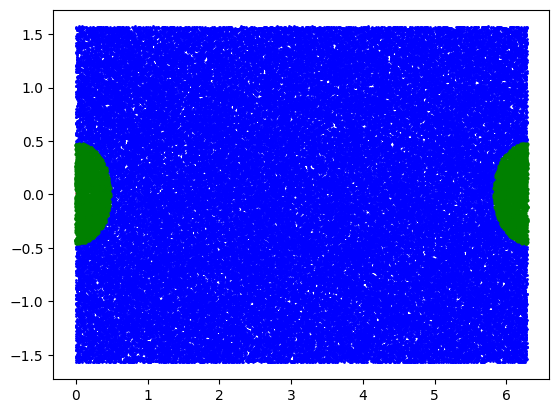

In [8]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot( cat[:,1], cat[:,0], 'o', ms = 1, color = 'blue' )  # plot the catalog

n_points = len( p )
for i in range( n_points ):
    val = (i + 1) / (n_points+1)
    plt.plot( p[i,1],      p[i,0],      'o', ms = 2, color = (val, 0., 0.) ) # test points
    plt.plot( cat[j[i],1], cat[j[i],0], 'o', ms = 2, color = (0., val, 0.) ) # neighbors

plt.show()

In [15]:
n_points = len( p )
for i in range( n_points ):
    d0 = dj[i]
    d1 = [haversine_distance(q, p[i]) for q in cat[j[i]]]
    print( np.allclose( d0, d1 ) )

True
True
